# Testing GPU-based IMRPhenom with Ripple
-- Comparison with LALSimulation and PyCBC

### Package Installations

In [34]:
! pip install lalsuite
! pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install ripplegw
! pip install matplotlib
! pip install gwosc
! pip install gwpy
! pip install scipy
! pip install numpy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 15.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.23
    Uninstalling jaxlib-0.4.23:
      Successfully uninstalled jaxlib-0.4.23
  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[noti

### Import Packages

In [1]:
# Disabling LAL warnings
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# Plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Generic
import time
import numpy as np
from math import pi
from functools import partial

In [2]:
# GWOSC Packages
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey

In [3]:
# JAX Packages
import jax
import jax.numpy as jnp

from jax import vmap
from functools import partial

# Jax jitted version of waveform gen returns NaNs without this
# It may also return NaNs if improper arguments are provided (eg. PhenomD args for PhenomPv2)
jax.config.update("jax_enable_x64", True)

# Enable this just in case the jitted function produces NaNs
jax.config.update("jax_debug_nans", True)

In [4]:
# Ripple fast waveform generation
from ripple import ms_to_Mc_eta
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD_hphc
from ripple.waveforms.IMRPhenomPv2 import gen_IMRPhenomPv2_hphc

In [5]:
# LALSimulation Packages
import lal
import lalsimulation as lalsim

In [6]:
# PyCBC Packages
import pycbc

from pycbc import pnutils
from pycbc.waveform import utils as wfutils
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.conversions import get_final_from_initial, tau_from_final_mass_spin

from scipy import signal

### @jax.jit benchmark for sanity check

In [7]:
# Running a benchmark provided on the JAX website
@jax.jit
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

# This takes about 2 ms for 1e6 values on the website
# Saw times as fast as 350 micro-seconds on this
# However, if we run Ripple and then try to run this, it gets slower (weird???)
x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

1.91 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## LALSimulation Implementaiton of IMRPhenomD

In [8]:
approximant = lalsim.SimInspiralGetApproximantFromString("IMRPhenomD")
m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 440.0 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
m1_kg = m1_msun*lal.MSUN_SI
m2_kg = m2_msun*lal.MSUN_SI
distance = dist_mpc*1e6*lal.PC_SI

# Params for freq domain waveform
f_min = 20.0
f_max = 2048.0
f_ref = f_min
df = 0.25
sample_length_in_s = 1./df

hp, hc = lalsim.SimInspiralChooseFDWaveform(m1_kg, m2_kg,
                                            0., 0., chi1,
                                            0., 0., chi2,
                                            distance, inclination,
                                            phic, 0, 0., 0.,
                                            df, f_min, f_max, f_ref,
                                            None, approximant)
hp_lalsim = hp.data.data
hc_lalsim = hc.data.data

Observed sample rate = 4096.0


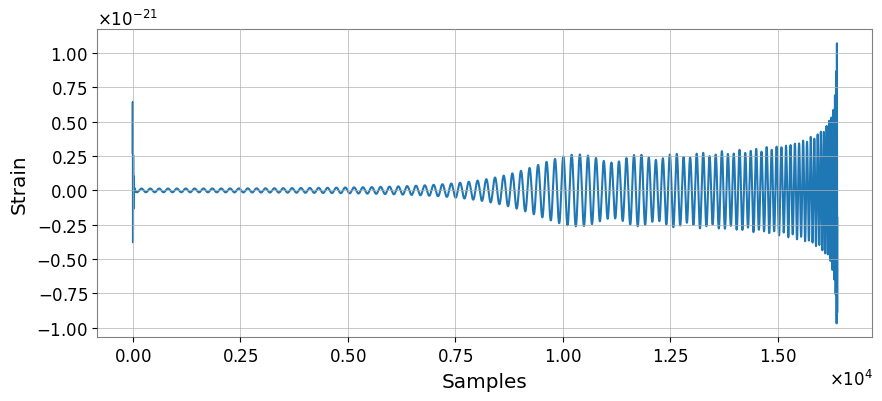

In [9]:
hp_lalsim_td = np.fft.irfft(hp_lalsim)
sample_rate = len(hp_lalsim_td)/sample_length_in_s
print('Observed sample rate = {}'.format(sample_rate))
hp_lalsim_td /= (1./sample_rate)

plt.figure(figsize=(10.0, 4.0))
plt.plot(hp_lalsim_td)
plt.xlabel('Samples')
plt.ylabel('Strain')
plt.show()

## PyCBC Implementation of IMRPhenomD

### Getting a time-domain waveform for comparison

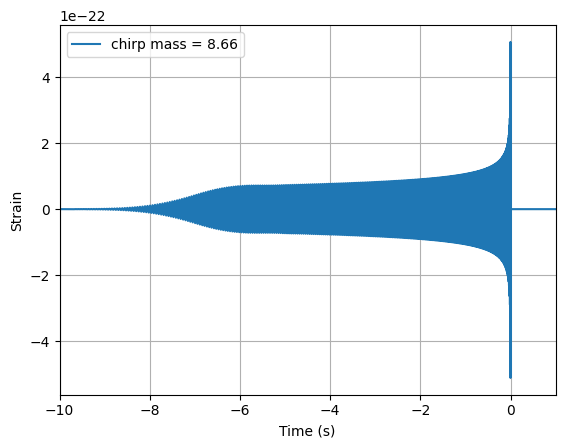

In [10]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform

m1_msun = 10.0 # In solar masses
m2_msun = 9.9
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 440.0 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0 # Polarization angle
mchirp = (m1_msun*m2_msun / (m1_msun+m2_msun)**2.)**(3./5) * (m1_msun + m2_msun)
mchirp = round(mchirp, 2)

f_ref = 20.0

for apx in ['IMRPhenomD']:
    hp_pycbc, hc_pycbc = get_td_waveform(approximant=apx,
                                    mass1=m1_msun,
                                    mass2=m2_msun,
                                    spin1z=chi1,
                                    spin2z=chi2,
                                    delta_t=1.0/4096.,
                                    f_lower=20.0,
                                    f_ref=20.0,
                                    distance=dist_mpc,
                                    polarization=polarization_angle,
                                    inclination=inclination)

    limits = slice(None, None)
    pp.plot(hp_pycbc.sample_times[limits], hp_pycbc[limits], label='chirp mass = {}'.format(mchirp))

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.xlim(-10, +1)
pp.grid()
pp.legend()
pp.show()

### Getting a frequency-domain waveform and converting to time-domain

In [11]:
"""
Plot a time domain and Fourier domain waveform together in the time domain.
Note that without special cleanup the Fourier domain waveform will exhibit
the Gibb's phenomenon. (http://en.wikipedia.org/wiki/Gibbs_phenomenon)
"""

import matplotlib.pyplot as pp
from pycbc import types, fft, waveform

# Get a frequency domain waveform
sptilde, sctilde = waveform.get_fd_waveform(approximant="IMRPhenomD",
                             mass1=20, mass2=19, delta_f=0.25, f_lower=20, distance=440.0)

# FFT it to the time-domain
sample_rate = 4096.0
tlen = int(1.0 / (1./sample_rate) / sptilde.delta_f)
sptilde.resize(int(tlen/2 + 1))
hp_pycbc_fd2td = types.TimeSeries(types.zeros(tlen), delta_t=1./sample_rate)
fft.ifft(sptilde, hp_pycbc_fd2td)
# check irfft with numpy
hp_pycbc_fd2td_np = np.fft.irfft(sptilde) / (1./sample_rate)


In [12]:
# Use the convert to TD function in PyCBC
waveform_kwargs = {}
waveform_kwargs['mass1'] = 20
waveform_kwargs['mass2'] = 19
waveform_kwargs['approximant'] = 'IMRPhenomD'
waveform_kwargs['delta_f'] = 0.1
waveform_kwargs['delta_t'] = 1./sample_rate
waveform_kwargs['distance'] = 440.0
waveform_kwargs['f_lower'] = 20

start = time.time()
hp_corrected, hc_corrected = waveform.get_td_waveform_from_fd(**waveform_kwargs)
end = time.time() - start
print('Time taken for conversion from fd to td via PyCBC = {}'.format(end))

Time taken for conversion from fd to td via PyCBC = 0.02376556396484375


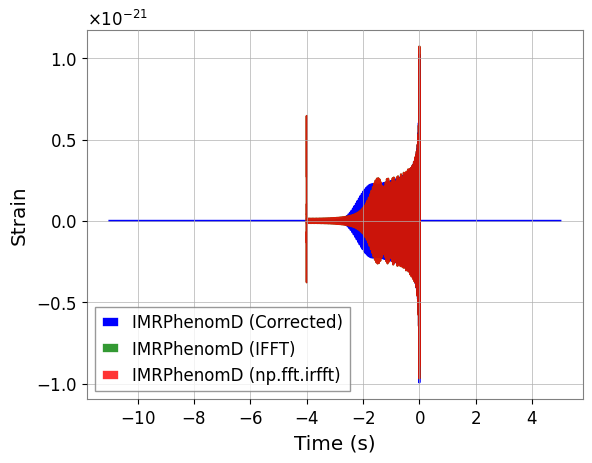

In [13]:
pp.plot(hp_corrected.sample_times, hp_corrected, label='IMRPhenomD (Corrected)', color='blue')
pp.plot(hp_pycbc_fd2td.sample_times, hp_pycbc_fd2td, label="IMRPhenomD (IFFT)", alpha=0.8, color='green')
pp.plot(hp_pycbc_fd2td.sample_times, hp_pycbc_fd2td_np, label="IMRPhenomD (np.fft.irfft)", alpha=0.8, color='red')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

The PyCBC FD to TD function seems to apply a wrap-around, smooths out the Gibbs phenomenon and tapers both end of the waveform. Applying the corrections made by this function to Ripple should give us waveforms that are consistent with PyCBC.

### Comparison with LALSimulation

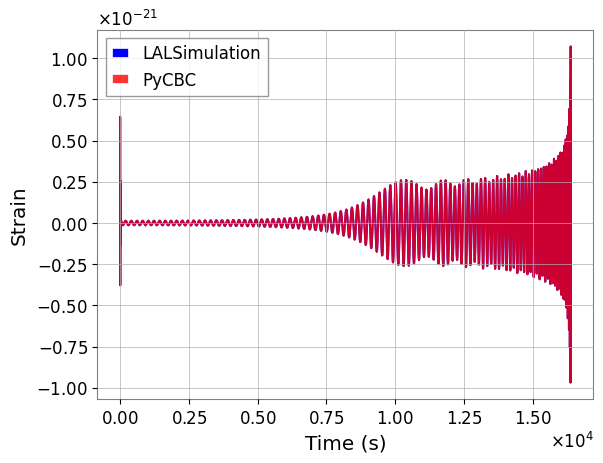

In [14]:
pp.plot(hp_lalsim_td, label='LALSimulation', color='blue')
pp.plot(hp_pycbc_fd2td_np, label="PyCBC", alpha=0.8, color='red')

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

{0.0}


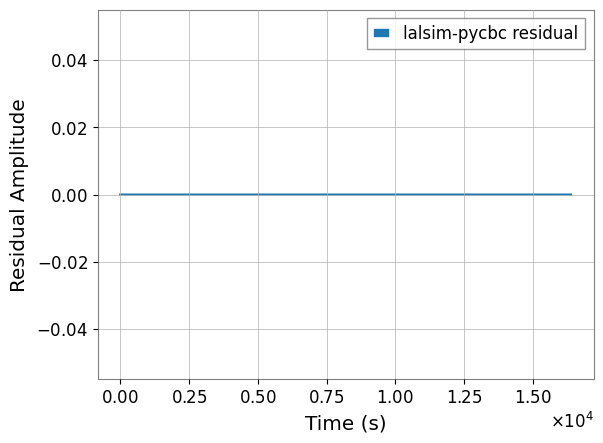

In [15]:
# For obvious reasons, the residual should be zero
print(set(hp_lalsim_td-hp_pycbc_fd2td_np))
pp.plot(hp_lalsim_td-hp_pycbc_fd2td_np, label='lalsim-pycbc residual')

pp.ylabel('Residual Amplitude')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

## Ripple Implementation of IMRPhenomD

In [16]:
IMRphenom = 'IMRPhenomD'

m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 440.0 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0 # Polarization angle

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

params = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])

# Get a frequency domain waveform
f_l = 20.0
f_u = 2048.0
df = 0.25
f_ref = f_l

fs = np.append(np.arange(0.0, f_u, df), 2048.)
print(fs)

[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
 2.04800e+03]


In [17]:
def waveform(theta):
    hp, _ = gen_IMRPhenomD_hphc(fs[1:], theta, f_ref)
    return hp

In [18]:
hp_ripple = waveform(params)
# restore zero-frequency component
hp_ripple = np.insert(hp_ripple, 0, 0)
hp_ripple = np.array(hp_ripple)
hp_ripple[fs < 20] = 0.0 # ad-hoc high pass filtering
print(hp_ripple)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


### Comparison of Ripple and LALSimulation

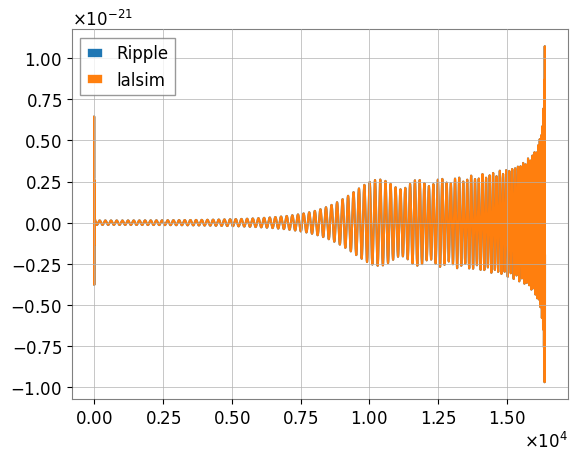

Sample duration observed (Ripple) = 4.0
Length of sample (Ripple) = 16384
Observed sample rate = 4096.0


In [19]:
hp_ripple_td = np.fft.irfft(hp_ripple)
sample_rate = len(hp_ripple_td)/(1./df)
hp_ripple_td /= (1./sample_rate)
plt.plot(hp_ripple_td, label='Ripple')
plt.plot(hp_lalsim_td, label='lalsim')
plt.legend()
plt.show()

print('Sample duration observed (Ripple) = {}'.format(len(hp_ripple_td)/4096.))
print('Length of sample (Ripple) = {}'.format(len(hp_ripple_td)))
print('Observed sample rate = {}'.format(sample_rate))

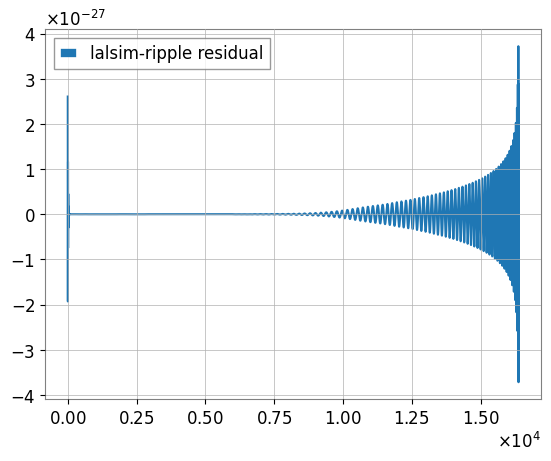

In [20]:
plt.plot(hp_lalsim_td-hp_ripple_td, label='lalsim-ripple residual')
plt.legend()
plt.show()

## Converting FD waveform to TD and cleaning-up (PyCBC and Ripple)

In [21]:
def get_imr_length(approx, **kwds):
    """ Call through to pnutils to obtain IMR waveform durations """
    m1 = float(kwds['mass1'])
    m2 = float(kwds['mass2'])
    s1z = float(kwds['spin1z'])
    s2z = float(kwds['spin2z'])
    f_low = float(kwds['f_lower'])
    # 10% margin of error is incorporated in the pnutils function
    return pnutils.get_imr_duration(m1, m2, s1z, s2z, f_low, approximant=approx)

In [22]:
def imrphenomd_length_in_time(**kwds):
    """ Stub for holding the calculation of IMRPhenomD waveform duration """
    return get_imr_length("IMRPhenomD", **kwds)

In [23]:
rwrap = None

# Filter time lengths for waveform approximants
_filter_time_lengths = {}
_filter_time_lengths["IMRPhenomD"] = imrphenomd_length_in_time
_filter_time_lengths["IMRPhenomPv2"] = imrphenomd_length_in_time
_filter_time_lengths["IMRPhenomXPHM"] = imrphenomd_length_in_time

In [24]:
# Check waveform kwargs before proceeding
# Use the convert to TD function in PyCBC
waveform_kwargs = {}
waveform_kwargs['mass1'] = 49
waveform_kwargs['mass2'] = 43
waveform_kwargs['approximant'] = 'IMRPhenomD'
waveform_kwargs['distance'] = 440.0

params = waveform_kwargs
params['spin1z'] = 0.0
params['spin2z'] = 0.0
params['f_ref'] = 20.0
params['delta_f'] = 0.25
params['f_lower'] = 20.0
params['delta_t'] = 1./2048.

for item in params.items():
    print(item)

('mass1', 20)
('mass2', 19)
('approximant', 'IMRPhenomD')
('distance', 440.0)
('spin1z', 0.0)
('spin2z', 0.0)
('f_ref', 20.0)
('delta_f', 0.25)
('f_lower', 20.0)
('delta_t', 0.00048828125)


In [25]:
verbose = False

In [26]:
@jax.jit
def fast_ripple_IMRPhenomPv2(fs, theta, f_ref):
    data = gen_IMRPhenomPv2_hphc(fs, theta, f_ref)
    return data

def fast_ripple_IMRPhenomD(fs, theta, f_ref):
    data = gen_IMRPhenomD_hphc(fs, theta, f_ref)
    return data

In [27]:
## Doing the same thing step by step (understanding the inner working)
## Don't worry, I will clean this up soon

def fd_to_td(waveform_generator=None, rwrap=None, params=None, theta_ripple=None):
    nparams = params.copy()

    ### STEP 1: Calculation of rwrap ###
    if rwrap is None:
        # In the `pycbc.waveform.parameters` module, spin1z and
        # spin2z have the default value 0. Users must have input
        # masses, so no else is needed.
        mass_spin_params = set(['mass1', 'mass2', 'spin1z', 'spin2z'])
        if mass_spin_params.issubset(set(nparams.keys())):
            m_final, spin_final = get_final_from_initial(
                mass1=nparams['mass1'], mass2=nparams['mass2'],
                spin1z=nparams['spin1z'], spin2z=nparams['spin2z'])
            rwrap = tau_from_final_mass_spin(m_final, spin_final) * 10
            if rwrap < 5:
                # Long enough for very massive BBHs in XG detectors,
                # up to (3000, 3000) solar mass, while still not a
                # computational burden for 2G cases.
                rwrap = 5

    if nparams['approximant'] not in _filter_time_lengths:
        raise ValueError("Approximant %s _filter_time_lengths function \
                            not available" % (nparams['approximant']))
    
    ### STEP 2: Calculation of duration and new f_lower ###
    # determine the duration to use
    approximant = nparams['approximant']
    full_duration = duration = _filter_time_lengths[approximant](**nparams)

    while full_duration < duration * 1.5:
        full_duration = _filter_time_lengths[approximant](**nparams)
        nparams['f_lower'] *= 0.99
        if 't_obs_start' in nparams and \
            full_duration >= nparams['t_obs_start']:
            break

    if 'f_ref' not in nparams:
        nparams['f_ref'] = params['f_lower']

    # factor to ensure the vectors are all large enough. We don't need to
    # completely trust our duration estimator in this case, at a small
    # increase in computational cost
    fudge_duration = (max(0, full_duration) + .1 + rwrap) * 1.5
    fsamples = int(fudge_duration / nparams['delta_t'])
    N = pnutils.nearest_larger_binary_number(fsamples)
    fudge_duration = N * nparams['delta_t']

    nparams['delta_f'] = 1.0 / fudge_duration
    tsize = int(1.0 / nparams['delta_t'] /  nparams['delta_f'])
    fsize = tsize // 2 + 1

    if verbose:
        print('FD params needed to create TD waveform')
        for item in nparams.items():
            print(item)

    print(nparams)
    print(params)
    print(fsize)
    print(rwrap)

    ### STEP 3: Calculate the h_plus and h_cross in frequency domain ###   
    if waveform_generator == 'pycbc':
        print(nparams)
        hp, hc = pycbc.waveform.get_fd_waveform(**nparams)
    elif waveform_generator == 'ripple':
        theta = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
        print(theta)
        f_ref = 20.0 #Hz
        fs = np.append(np.arange(0.0, 2048., nparams['delta_f']), 2048.)
        print(len(fs))
        assert fs[-2]+nparams['delta_f'] == 2048., "fs = {}, check = {}".format(fs, fs[-2]+nparams['delta_f'])
        hp, hc = gen_IMRPhenomD_hphc(fs[1:], theta, f_ref)
        hp = np.insert(hp, 0, 0)
        hc = np.insert(hc, 0, 0)
        print(len(hp))
        hp[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
        hc[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
    elif waveform_generator == 'fast_ripple_IMRPhenomPv2':
        f_ref = 20.0 #Hz
        fs = np.append(np.arange(0.0, 2048., nparams['delta_f']), 2048.)
        print(len(fs))
        hp, hc = fast_ripple_IMRPhenomPv2(fs[1:], theta_ripple, f_ref)
        hp = np.insert(hp, 0, 0)
        hc = np.insert(hc, 0, 0)
        print(len(hp))
        hp[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
        hc[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
    elif waveform_generator == 'fast_ripple_IMRPhenomD':
        f_ref = 20.0 #Hz
        theta = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
        fs = np.append(np.arange(0.0, 2048., nparams['delta_f']), 2048.)
        hp, hc = fast_ripple_IMRPhenomD(fs[1:], theta, f_ref)

        hp = np.insert(hp, 0, 0)
        hc = np.insert(hc, 0, 0)
        hp[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
        hc[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering

    if verbose:
        print('Current data-type of hp = {}'.format(type(hp)))
    hp = np.array(hp)
    hc = np.array(hc)
    if verbose:
        print('We now convert the PyCBC FrequencySeries to a np.ndarray and back to FS with minimal effort')
        print('Current data-type of hp = {}'.format(type(hp)))
    hp = FrequencySeries(hp, delta_f=nparams['delta_f'])
    hc = FrequencySeries(hc, delta_f=nparams['delta_f'])
    if verbose:
        print('Current data-type of hp = {}'.format(type(hp)))
    

    ### STEP 4: Resize to get the correct sample rate ###
    # Resize to the right sample rate
    print('before resize = {}'.format(len(hp)))
    hp.resize(fsize)
    hc.resize(fsize)
    print('after resize = {}'.format(len(hp)))

    ### STEP 5: Correct for wraparound introduced by LAL ###
    # avoid wraparound
    hp = hp.cyclic_time_shift(-rwrap)
    hc = hc.cyclic_time_shift(-rwrap)

    ### STEP 6: Taper low freq edge and convert to time domain ###
    # Removed delta_t from params as it is fixed to 2048 Hz
    hp = wfutils.fd_to_td(hp, left_window=(nparams['f_lower'], params['f_lower']))
    hc = wfutils.fd_to_td(hc, left_window=(nparams['f_lower'], params['f_lower']))
    
    assert hp.delta_t == params['delta_t']
    assert hc.delta_t == params['delta_t']
    print('Length of sample in seconds for hp and hc')
    print(len(hp)*hp.delta_t, len(hc)*hc.delta_t)

    ### STEP 7: PARTAAY ###
    return hp, hc

### Cleaning up the PyCBC FD output with the clean-up function

{'mass1': 20, 'mass2': 19, 'approximant': 'IMRPhenomD', 'distance': 440.0, 'spin1z': 0.0, 'spin2z': 0.0, 'f_ref': 20.0, 'delta_f': 0.0625, 'f_lower': 17.02915542189751, 'delta_t': 0.00048828125}
{'mass1': 20, 'mass2': 19, 'approximant': 'IMRPhenomD', 'distance': 440.0, 'spin1z': 0.0, 'spin2z': 0.0, 'f_ref': 20.0, 'delta_f': 0.25, 'f_lower': 20.0, 'delta_t': 0.00048828125}
16385
5
{'mass1': 20, 'mass2': 19, 'approximant': 'IMRPhenomD', 'distance': 440.0, 'spin1z': 0.0, 'spin2z': 0.0, 'f_ref': 20.0, 'delta_f': 0.0625, 'f_lower': 17.02915542189751, 'delta_t': 0.00048828125}
before resize = 32769
after resize = 16385
Length of sample in seconds for hp and hc
16.0 16.0


Text(0, 0.5, 'Strain')

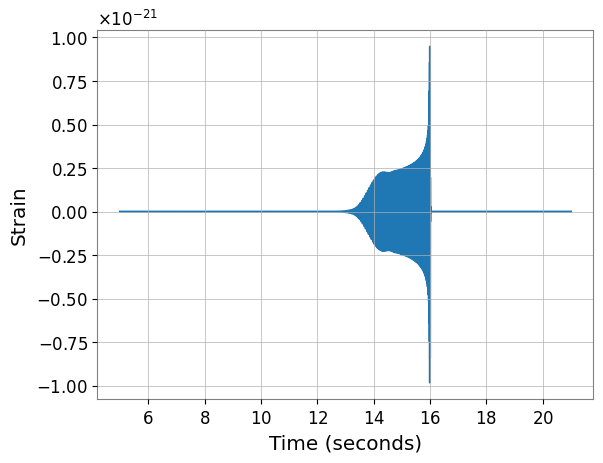

In [28]:
hp_pycbc_corrected, _ = fd_to_td('pycbc', rwrap, params)
pp.plot(hp_pycbc_corrected.sample_times, hp_pycbc_corrected)
pp.xlabel('Time (seconds)')
pp.ylabel('Strain')

This means that we don't need any information other than updated delta_f in order to make a PyCBC Frequency series. Hopefully, this is fine with the constrain added to Ripple (it always seems to output data with sample rate = 4096.0 Hz)

### Check if the clean-up function works with Ripple

{'mass1': 20, 'mass2': 19, 'approximant': 'IMRPhenomD', 'distance': 440.0, 'spin1z': 0.0, 'spin2z': 0.0, 'f_ref': 20.0, 'delta_f': 0.0625, 'f_lower': 17.02915542189751, 'delta_t': 0.00048828125}
{'mass1': 20, 'mass2': 19, 'approximant': 'IMRPhenomD', 'distance': 440.0, 'spin1z': 0.0, 'spin2z': 0.0, 'f_ref': 20.0, 'delta_f': 0.25, 'f_lower': 20.0, 'delta_t': 0.00048828125}
16385
5
before resize = 32769
after resize = 16385
Length of sample in seconds for hp and hc
16.0 16.0


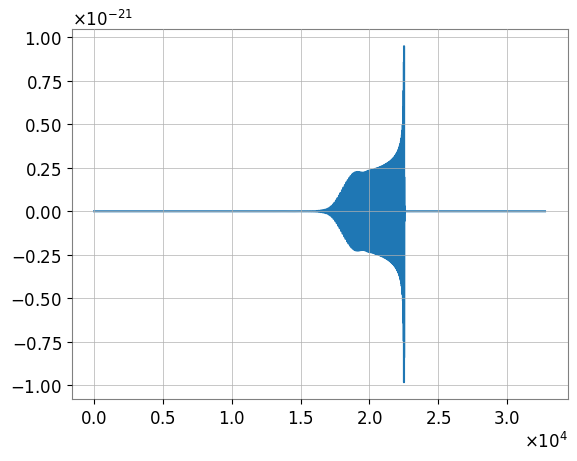

In [29]:
hp_ripple_corrected, _ = fd_to_td('fast_ripple_IMRPhenomD', rwrap, params)
pp.plot(hp_ripple_corrected)

IT'S ALIVE!!

### Compare the cleaned TD results between PyCBC and Ripple

Text(0.5, 1.0, 'Residual between pycbc and ripple for FD to TD with cleanup')

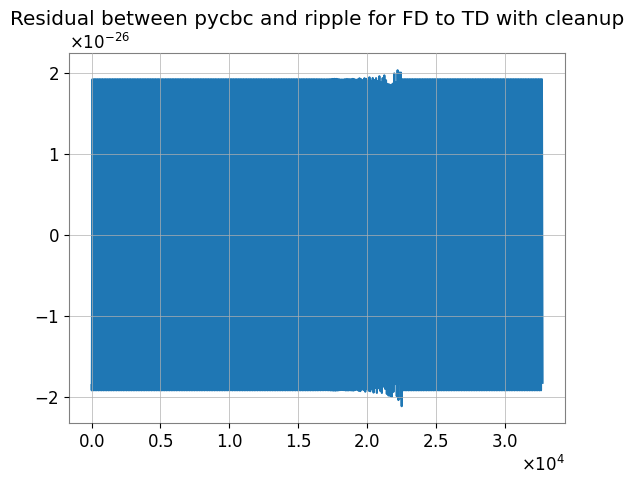

In [30]:
pp.plot(hp_ripple_corrected-hp_pycbc_corrected)
pp.title('Residual between pycbc and ripple for FD to TD with cleanup')

## Ripple Implementation of IMRPhenomPv2 with JIT for fast waveform generation

In [31]:
# Now we need to generate the frequency grid
# Sampling frequency
f_l = 20
f_u = 2048
del_f = 0.25
sample_length_in_s = 1./del_f
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

In [32]:
def get_waveform_kwargs(mass):
    # And finally lets generate the waveform (IMRPhenomPv2)!
    # Get a frequency domain waveform
    # source parameters
    m1_msun = mass
    m2_msun = mass - 1
    s1x = 0.0
    s1y = 0.0
    s1z = 0.0
    s2x = 0.0
    s2y = 0.0
    s2z = 0.0
    dist_mpc = 440.0
    tc = 0.0
    phiRef = 0.0
    incl = 0.0
    
    Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
    theta_ripple = jnp.array([Mc, eta, s1x, s1y, s1z, s2x, s2y, s2z, dist_mpc, tc, phiRef, incl])

    return theta_ripple

In [33]:
@jax.jit
def waveform_generate(theta):
    data = gen_IMRPhenomPv2_hphc(fs, theta, f_ref)
    return data

In [34]:
# Time taken for producing 1000 waveforms (same waveform)
num_waveforms = 1500
key = jax.random.PRNGKey(42)
theta_ripple = get_waveform_kwargs(jax.random.uniform(key, minval=6.0, maxval=50.0))

start = time.time()
for idx in range(num_waveforms):
    hp_ripple, hc_ripple = waveform_generate(theta_ripple)
end = time.time() - start
print('Time taken to produce num_waveforms = {} with Ripple-JIT = {} seconds'.format(num_waveforms, end))

Time taken to produce num_waveforms = 1500 with Ripple-JIT = 5.541683912277222 seconds


In [35]:
print('Time taken to get one waveform is approximately = {} ms'.format((end/num_waveforms)*1000.))

Time taken to get one waveform is approximately = 3.694455941518148 ms


In [36]:
# Creating 10000 of the same waveform parameters for testing jitted waveform generator with vmap|
single_waveform = waveform_generate(theta_ripple)
thetas = jnp.ones(10000)[None,:] * theta_ripple[:,None]
thetas.shape

(12, 10000)

In [37]:
# Apply vmap for a vectorised waveform generation
vectorised = vmap(waveform_generate, in_axes=(1,))

start = time.time()
waveforms = vectorised(thetas)
end = time.time() - start

waveforms = np.array(waveforms)
print('Shape of waveforms generated = {}'.format(waveforms.shape))
print('Time taken to produce 10_000 IMRPhenomPv2 waveforms (jitted, vmap) = {} s'.format(end))

Shape of waveforms generated = (2, 10000, 8112)
Time taken to produce 10_000 IMRPhenomPv2 waveforms (jitted, vmap) = 5.654818534851074 s


In [38]:
# Sanity check to see if vmap worked properly
jnp.allclose(single_waveform[0], waveforms[0][0])

Array(True, dtype=bool)

In [39]:
print('Time taken on average to obtain one waveform using vmap and jit = {} ms'.format((end/10000)*1000.))

Time taken on average to obtain one waveform using vmap and jit = 0.5654818534851074 ms


This is very good! Not quite as fast as mentioned on the Ripple paper (https://arxiv.org/abs/2302.05329) - 0.02 ms, even on IMRPhenomD. Maybe, we are missing something. Nevertheless, this is perfect. With this speed, we should be able to do on-the-fly data generation quite easily. 

## Optimising fast waveform generation for IMRPhenomPv2 with TD domain clean-up

### How fast is IMRPhenonPv2 and FD clean-up with JIT? (not optimised)

In [ ]:
num_waveforms = 100
theta_ripple = get_waveform_kwargs(idx+800)

start = time.time()
for _ in range(num_waveforms):
    hp, hc = fd_to_td('fast_ripple_IMRPhenomPv2', rwrap, params, theta_ripple)
end = time.time() - start

print('Time taken for fast Ripple IMRPhenomPv2 (nwaveforms = {}) = {}'.format(num_waveforms, end))

This takes longer than expected because we haven't used JAX to define the array manipulations. Let's incorporate those changes and see if we can get this number down.

### Is this faster with IMRPhenomD? (TLDR; Not by much)

In [ ]:
num_waveforms = 100
start = time.time()
for _ in range(num_waveforms):
    hp, hc = fd_to_td('fast_ripple_IMRPhenomD', rwrap, params)
end = time.time() - start

print('Time taken for fast Ripple IMRPhenomD (nwaveforms = {}) = {}'.format(num_waveforms, end))

It's not that much faster. Let's try and time each step for optimisation.

### How does the unoptimised Ripple code compare to PyCBC (which doesn't use JIT) for IMRPhenomD?

In [ ]:
num_waveforms = 100
start = time.time()
for _ in range(num_waveforms):
    hp, hc = fd_to_td('pycbc', rwrap, params)
end = time.time() - start

print('Time taken for PyCBC IMRPhenomD (nwaveforms = {}) = {}'.format(num_waveforms, end))

In [43]:
## How fast is PyCBC without any of the clean-up stuff? 
num_waveforms = 220
start = time.time()
for _ in range(num_waveforms):
    hp, hc = pycbc.waveform.get_fd_waveform(**params)
end = time.time() - start
print('Time taken to produce num_waveforms = {} with PyCBC for IMRPhenomD = {}'.format(num_waveforms, end))

Time taken to produce num_waveforms = 220 with PyCBC for IMRPhenomD = 0.9656641483306885


### Running IMRPhenomD on Ripple with clean-up and without JIT (should be super slow)

In [ ]:
num_waveforms = 100
start = time.time()
for _ in range(num_waveforms):
    hp, hc = fd_to_td('ripple', rwrap, params)
end = time.time() - start

# Wow, that's quite slow.
print('Time taken for fast Ripple IMRPhenomD (nwaveforms = {}) = {}'.format(num_waveforms, end))

### Breaking down the clean-up process and using jnp for optimisation

#### Initial parameters

In [45]:
# Check waveform kwargs before proceeding
# Use the convert to TD function in PyCBC
waveform_kwargs = {}
waveform_kwargs['mass1'] = 20
waveform_kwargs['mass2'] = 19
waveform_kwargs['approximant'] = 'IMRPhenomD'
waveform_kwargs['distance'] = 440.0

params = waveform_kwargs
params['spin1z'] = 0.0
params['spin2z'] = 0.0
params['f_ref'] = 20.0
params['delta_f'] = 0.25
params['f_lower'] = 20.0
params['delta_t'] = 1./4096.

for item in params.items():
    print(item)

('mass1', 20)
('mass2', 19)
('approximant', 'IMRPhenomD')
('distance', 440.0)
('spin1z', 0.0)
('spin2z', 0.0)
('f_ref', 20.0)
('delta_f', 0.25)
('f_lower', 20.0)
('delta_t', 0.000244140625)


In [46]:
# Copy params dict for manipulation
nparams = params.copy()

#### Optimising rwrap in the fd_to_td function

In [47]:
""" ORIGINAL IMPLEMENTATION (as seen on PyCBC documentation) """
# In the `pycbc.waveform.parameters` module, spin1z and
# spin2z have the default value 0. Users must have input
# masses, so no else is needed.
mass_spin_params = set(['mass1', 'mass2', 'spin1z', 'spin2z'])
if mass_spin_params.issubset(set(nparams.keys())):
    m_final, spin_final = get_final_from_initial(
        mass1=nparams['mass1'], mass2=nparams['mass2'],
        spin1z=nparams['spin1z'], spin2z=nparams['spin2z'])
    rwrap = tau_from_final_mass_spin(m_final, spin_final) * 10
    if rwrap < 5:
        # Long enough for very massive BBHs in XG detectors,
        # up to (3000, 3000) solar mass, while still not a
        # computational burden for 2G cases.
        rwrap = 5

print('rwrap = {} seconds'.format(rwrap))

rwrap = 5 seconds


In [48]:
""" We can optimise the get_final_from_initial function if required """
# Check the rwrap values at rhe extremas of the mass parameter
# We can ignore the rwrap function altogether if we find this to be set to rwrap = 5 in all cases
def check_rwrap(m1, m2, chi1, chi2):
    m_final, spin_final = get_final_from_initial(mass1=m1, mass2=m2, spin1z=chi1, spin2z=chi2)
    rwrap = tau_from_final_mass_spin(m_final, spin_final) * 10
    if rwrap < 5:
        print('Failed: rwrap not required for the given mass+spin parameter set, rwrap ({}) < 5'.format(rwrap))
    else:
        print('Passed: rwrap is required for given mass+spin parameter set, rwrap ({}) >= 5'.format(rwrap))


In [49]:
# Lowest chirp mass possible (non-spinning)
check_rwrap(m1=5.0, m2=4.9, chi1=0.0, chi2=0.0)

Failed: rwrap not required for the given mass+spin parameter set, rwrap (0.005709369877343962) < 5


In [50]:
# Lowest chirp mass possible (spinning)
check_rwrap(m1=5.0, m2=4.9, chi1=0.99, chi2=-0.99)

Failed: rwrap not required for the given mass+spin parameter set, rwrap (0.005724958915744104) < 5


In [51]:
# Highest chirp mass possible (non-spinning)
check_rwrap(m1=100.0, m2=99.9, chi1=0.0, chi2=0.0)

Failed: rwrap not required for the given mass+spin parameter set, rwrap (0.1152849995068931) < 5


In [52]:
# Highest chirp mass possible (spinning)
check_rwrap(m1=100.0, m2=99.9, chi1=0.99, chi2=0.99)

Failed: rwrap not required for the given mass+spin parameter set, rwrap (0.1632940315793305) < 5


In [53]:
# Where does rwrap actually go to large enough values
# m1, m2 of {3000, 3000} is the limit
check_rwrap(m1=3000.0, m2=3000.0, chi1=0.99, chi2=0.99) # Failed
check_rwrap(m1=3100.0, m2=3100.0, chi1=0.99, chi2=0.99) # Passed

Failed: rwrap not required for the given mass+spin parameter set, rwrap (4.901270227338983) < 5
Passed: rwrap is required for given mass+spin parameter set, rwrap (5.064645901583616) >= 5


Can we reduce this rwrap value to something smaller given the mass and spin parameter space in which we are working? This might be possible.

#### Optimising the _filter_time_lengths function using jnp

In [54]:
# determine the duration to use
approximant = nparams['approximant']
start = time.time()
full_duration = duration = _filter_time_lengths[approximant](**nparams)
end = time.time() - start

print('Initial full duration = {} seconds'.format(full_duration))
print('Time taken to calculate signal duration given nparams = {} seconds'.format(end))

Initial full duration = 2.0590079746328094 seconds
Time taken to calculate signal duration given nparams = 0.0007815361022949219 seconds


In [55]:
# f_lower is changed such that the duration is 1.5 times the originally intended duration
start = time.time()
counter = 0
while True:
    print(full_duration, duration)
    full_duration = _filter_time_lengths[approximant](**nparams)
    if full_duration >= duration * 1.5:
        break
    else:
        # This will reduce the number of iterations in _filter_time_lenghts
        # It will consequently increase the time taken for waveform generation process
        # But, we've already seen that this shouldn't matter much for Ripple
        nparams['f_lower'] -= 3.0
    counter+=1
end = time.time() - start

print('Updated f_lower = {} Hz'.format(nparams['f_lower']))
print('Updated full duration = {} seconds'.format(full_duration))
print('Time taken to update full_duration {} times= {}'.format(counter, end))

2.0590079746328094 2.0590079746328094
2.0590079746328094 2.0590079746328094
Updated f_lower = 17.0 Hz
Updated full duration = 3.228161538403766 seconds
Time taken to update full_duration 1 times= 0.001520395278930664


In [56]:
# factor to ensure the vectors are all large enough. We don't need to
# completely trust our duration estimator in this case, at a small
# increase in computational cost
start = time.time()
fudge_duration = (max(0, full_duration) + .1 + rwrap) * 1.5
fsamples = int(fudge_duration / nparams['delta_t'])
N = pnutils.nearest_larger_binary_number(fsamples)
fudge_duration = N * nparams['delta_t']

nparams['delta_f'] = 1.0 / fudge_duration
tsize = int(1.0 / nparams['delta_t'] /  nparams['delta_f'])
fsize = tsize // 2 + 1
end = time.time() - start

print('Time taken for fudge duration stuff = {} seconds'.format(end))

Time taken for fudge duration stuff = 0.00019812583923339844 seconds


In [57]:
@jax.jit
def dummy_time_length(nparams):
    return 1.1 * lalsim.SimIMRPhenomDChirpTime(nparams['mass1']*1.989e+30, nparams['mass2']*1.989e+30, 
                                               nparams['spin1z'], nparams['spin2z'], 
                                               nparams['f_lower'])

In [58]:
_nparams = {}
_nparams['mass1'] = 20.0
_nparams['mass2'] = 19.0
_nparams['spin1z'] = 0.0
_nparams['spin2z'] = 0.0
_nparams['f_lower'] = 20.0
start = time.time()
#dummy_time_length(nparams)
end = time.time() - start
print('Time taken to calculate IMR signal duration using lalsim = {} seconds'.format(end))

"""
Should lead to the following error message if run:
TypeError: in method 'SimIMRPhenomDChirpTime', argument 1 of type 'REAL8'
"""

Time taken to calculate IMR signal duration using lalsim = 1.5974044799804688e-05 seconds


"\nShould lead to the following error message if run:\nTypeError: in method 'SimIMRPhenomDChirpTime', argument 1 of type 'REAL8'\n"

#### Optimising the freq clean-up after waveform generation

In [59]:
f_ref = 20.0 #Hz
# Convert into jnp array
fs = np.append(np.arange(0.0, 2048., nparams['delta_f']), 2048.)

start = time.time()

# Use jnp functions to define theta
hp, hc = fast_ripple_IMRPhenomPv2(fs[1:], theta_ripple, f_ref)

# Use jnp for the insert operation
hp = np.insert(hp, 0, 0)
hc = np.insert(hc, 0, 0)
# This should be possible via jnp as well
hp[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering
hc[fs < nparams['f_lower']] = 0.0 # ad-hoc high pass filtering

end = time.time() - start

print('Time taken to produce a signal and apply an ad-hoc high pass filter = {} seconds'.format(end))

Time taken to produce a signal and apply an ad-hoc high pass filter = 0.0030698776245117188 seconds


In [60]:
start = time.time()

# Use jnp functions to define theta
hp, hc = pycbc.waveform.get_fd_waveform(**nparams)
end = time.time() - start

print('Time taken to produce a signal using PyCBC = {} seconds'.format(end))

Time taken to produce a signal using PyCBC = 0.006681203842163086 seconds


It looks like PyCBC is about 3 times slower than JAX jitted version of IMRPhenomPv2. It might be worthy to note that, when using CUDA disabled Ripple, PyCBC (without ad-hoc high-pass filtering) and Ripple (with ad-hoc high-pass filtering) functions take about the same amount of computational time = 0.005 seconds. The speed-up is observed when using the CUDA-enabled version of JAX. We can further speed-up the waveform generation process in Ripple by using vmap to create a batch at a time. We should pair this with the BatchSampler in Pytorch to create a fast batrch loader. 

In [61]:
@jax.jit
def dummy(fs):
    # Use jnp functions to define theta
    hp, hc = gen_IMRPhenomPv2_hphc(fs[1:], theta_ripple, f_ref)
    return hp, hc

In [62]:
fs = jnp.append(jnp.arange(0.0, 2048., nparams['delta_f']), 2048.)
idxs = np.where(fs < nparams['f_lower'])

start = time.time()
hp, hc = dummy(fs)
# Use jnp for the insert operation
hp = np.insert(hp, 0, 0)
hc = np.insert(hc, 0, 0)
# This should be possible via jnp as well
hp[idxs] = 0.0 # ad-hoc high pass filtering
hc[idxs] = 0.0 # ad-hoc high pass filtering
end = time.time() - start

print('Time taken to produce a signal and apply an ad-hoc high pass filter = {} seconds'.format(end))

Time taken to produce a signal and apply an ad-hoc high pass filter = 3.264195203781128 seconds


Writing the insert and boolean indexing via jnp seems to slow things down 10 fold. Not sure what I'm doing wrong. Let's just keep it the way it is and only speed-up waveform generation. We still observe a 5-6 times speed-up compared to PyCBC which might be enough for on-the-fly waveform generation.

#### Optimising the PyCBC resizing via jax

In [63]:
""" Resizing function rewritten using jax.numpy module """
@jax.jit
def fast_resize():
    # Use jnp to speed things up
    return hp[0:fsize]

In [64]:
start = time.time()
hp_resized = hp[:fsize]
hc_resized = hc[:fsize]
end = time.time() - start
print('Time taken for numpy resizing = {} seconds'.format(end))

Time taken for numpy resizing = 0.00010466575622558594 seconds


In [65]:
start = time.time()
hp_resized = fast_resize()
end = time.time() - start
print('Time taken for numpy resizing = {} seconds'.format(end))

Time taken for numpy resizing = 0.30388736724853516 seconds


We can combine this the waveform generation function. Don't understand why slicing is so slow with jit. It seems much faster to use the regular numpy version instead of the jax jitted version.

#### Optimising the PyCBC cyclic time shift function via jax

In [66]:
# The PyCBC schemed optimisation makes apply_fseries_time_shift not so transparent
# We can just use jnp on the generic version of time shift
fseries = jnp.array(fs)
dt = nparams['delta_t']

In [67]:
@jax.jit
def dummy_shift():
    return hp * jnp.exp(-2j*jnp.pi*dt*fseries)

In [68]:
start = time.time()
hp = dummy_shift()
end = time.time() - start
print('Time taken for jitted version = {} seconds'.format(end))

Time taken for jitted version = 0.2729320526123047 seconds


In [69]:
start = time.time()
hp = hp * np.exp(-2j*np.pi*dt*fseries)
end = time.time() - start
print('Time taken for jitted version = {} seconds'.format(end))

Time taken for jitted version = 0.4972958564758301 seconds


Cyclic shift seems to be faster via the jitted version than the numpy version. I don't really get a sense of why a certain jitted function is faster than another. TODO: Look at JAX and JIT documentation for a better understanding.

#### Optimising the wfuitls.fd_to_td function

In [70]:
# tapering params
end = 2048.
start = 20.
beta = 8
delta_f = nparams['delta_f']

# windowing params
width = end - start
winlen = int(2 * (width / delta_f))
window = np.array(signal.get_window(('kaiser', beta), winlen))
kmin = int(start / delta_f)
kmax = kmin + winlen//2

In [71]:
# Original fd_taper function as defined in PyCBC
@jax.jit
def fd_taper_left(out):
    out = out.copy()
    out.at[kmin:kmax].set(out[kmin:kmax] * window[:winlen//2])
    out.at[:kmin].set(out[:kmin] * 0.)
    return out

In [72]:
# Converting the above function to a jitted version if possible
start = time.time()
out = fd_taper_left(hp)
end = time.time() - start
print('Time taken for fd_taper = {} seconds'.format(end))

Time taken for fd_taper = 0.02227950096130371 seconds


This is quite fast without being bogged down by unnecessary param calculations. It looks like we have to create a new dataset object class that saves these params in RAM before the job starts.

#### Total time taken after making each step as fast as possible

In [73]:
total_time_taken = 0.0006 + 0.001 + 0.0005 + 0.0005 + 0.0005
print('Total time taken for signal generation = {} seconds'.format(total_time_taken))

Total time taken for signal generation = 0.0031 seconds


This looks like it should be fine. Assuming that this can go up to 0.01 seconds per waveform generation, it should still do fine given that MR sampling is slower than this.

## Incorporating Ripple Fast Waveform Generation into ORChiD

In [15]:
# Transform written under the SignalWrapper in ORChiD
class FastGenerateWaveform():
    ## Used to augment on all parameters (uses GPU-accelerated IMRPhenomPv2 waveform generation)
    ## Link to Ripple: https://github.com/tedwards2412/ripple
    def __init__(self):
        # Generate the frequency grid (default values)
        self.f_lower = 20.
        self.f_upper = 2048.
        self.delta_f = 0.25 # dummy
        self.delta_t = 1./2048.
        self.f_ref = self.f_lower
        # Clean-up params
        self.rwrap = 3.0
        # Tapering params
        beta = 8
        # Condition for optimise f_min
        self.duration_padfactor = 1.1
        # Pick the longest waveform from priors to make some params static
        # Below params are for m1 = 5.01, m2 = 5.0 and with aligned spins s1z, s2z = 0.99
        _theta = {'mass1': 5.01, 'mass2': 5.0, 'spin1z': 0.99, 'spin2z': 0.99}
        self.tmp_f_lower, self.tmp_delta_f, self.fsize = self.optimise_fmin(_theta)
        print(self.tmp_f_lower, self.tmp_delta_f, self.fsize)
        # Get the fseries over which we get the waveform in FD
        self.fseries = jnp.append(jnp.arange(0.0, self.f_upper, self.tmp_delta_f), self.f_upper)
        fseries_trunc = self.fseries[:self.fsize]
        self.cshift = jnp.exp(-2j*jnp.pi*(-self.rwrap)*fseries_trunc)
        self.clean_idx = self.fseries < self.tmp_f_lower
        # Windowing params
        self.width = self.f_lower - self.tmp_f_lower
        self.winlen = int(2. * (self.width / self.tmp_delta_f))
        self.window = np.array(signal.get_window(('kaiser', beta), self.winlen))
        self.kmin = int(self.tmp_f_lower / self.tmp_delta_f)
        self.kmax = self.kmin + self.winlen//2
    
    def __str__(self):
        data = "f_lower = {}, f_upper = {}, \n \
        delta_f = {}, delta_t = {}, f_ref = {}, \n \
        rwrap = {}".format(self.f_lower, self.f_upper, self.delta_f,
                                   self.delta_t, self.f_ref, self.rwrap)
        return data

    """ ONE-OFF FUNCTIONS (Dont't require JAX or to be jitted in any way) """
    def ms_to_Mc_eta(self, masses):
        ## Converts binary component masses to chirp mass and symmetric mass ratio.
        m1, m2 = masses
        return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

    def get_imr_duration(self, theta, f_lower):
        # This function is applicable for IMRPhenomD and IMRPhenomPv2
        # Multiplying by a factor of 1.1 for overestimate of signal duration
        return 1.1 * lalsim.SimIMRPhenomDChirpTime(theta['mass1']*1.989e+30, theta['mass2']*1.989e+30, 
                                                   theta['spin1z'], theta['spin2z'], 
                                                   f_lower)
    
    def nearest_larger_binary_number(self, input_len):
        # Return the nearest binary number larger than input_len.
        return int(2**np.ceil(np.log2(input_len)))

    def optimise_fmin(self, theta):
        ## NOTE: We find that even for the longest duration waveform we deal with
        ## the value of f_lower is still 17.02 Hz (we can fix this value and remove this function)
        # determine the duration to use
        full_duration = duration = self.get_imr_duration(theta, self.f_lower)
        tmp_f_lower = self.f_lower
        while True:
            # This iteration is typically done 16 times
            full_duration = self.get_imr_duration(theta, tmp_f_lower)
            condition = duration * self.duration_padfactor
            if full_duration >= condition:
                break
            else:
                # We can change this to tmp_f_lower -= 3.0 to lower iterations
                # It will consequently increase the time taken for waveform generation process
                # But, we've already seen that this shouldn't matter much for Ripple
                # tmp_f_lower *= 0.99 is consistent with PyCBC docs
                tmp_f_lower *= 0.99

        # factor to ensure the vectors are all large enough. We don't need to
        # completely trust our duration estimator in this case, at a small
        # increase in computational cost
        fudge_duration = (full_duration + .1 + self.rwrap) * self.duration_padfactor
        fsamples = int(fudge_duration / self.delta_t)
        N = self.nearest_larger_binary_number(fsamples)
        fudge_duration = N * self.delta_t

        tmp_delta_f = 1.0 / fudge_duration
        tsize = int(1.0 / self.delta_t /  tmp_delta_f)
        fsize = tsize // 2 + 1

        return (tmp_f_lower, tmp_delta_f, fsize)
    
    """ NON-JITTABLES """
    # Using jnp and jitting this function caused significant slowdown
    # Might have something to do with multiple compilations
    def ripple_cleanup(self, hpol):
        # Add the 0th frequency bin back into the fseries
        hpol = np.insert(hpol, 0, 0)
        # ad-hoc high pass filtering
        hpol[self.clean_idx] = 0.0
        return hpol
    
    """ JITTABLES """
    # Jitting these functions require the first argument (self) to be defined as static
    @partial(jax.jit, static_argnums=(0,))
    def ripple_cleanup_jitted(self, hpol):
        # Add the 0th frequency bin back into the fseries
        hpol = jnp.insert(hpol, 0, 0)
        # ad-hoc high pass filtering
        hpol = hpol.at[self.clean_idx].set(0.0)
        return hpol
    
    @partial(jax.jit, static_argnums=(0,))
    def convert_to_timeseries(self, hpol):
        ## Convert frequency series to time series
        return jnp.fft.irfftn(hpol) * (1./self.delta_t)
    
    @partial(jax.jit, static_argnums=(0,))
    def fd_taper_left(self, out):
        # Apply Tapering
        out = out.at[self.kmin:self.kmax].set(out[self.kmin:self.kmax] * self.window[:self.winlen//2])
        out = out.at[:self.kmin].set(out[:self.kmin] * 0.)
        # Convert frequency series to time series
        out = self.convert_to_timeseries(out)
        return out
    
    @partial(jax.jit, static_argnums=(0,))
    def cyclic_time_shift(self, hpol):
        return hpol * self.cshift

    @partial(jax.jit, static_argnums=(0,))
    def resize(self, hpol):
        # Use jnp to speed things up
        return hpol[0:self.fsize]

    @partial(jax.jit, static_argnums=(0,))
    def get_theta_ripple(self, theta):
        # Convert the prior values to jnp array
        # Following params are required for IMRPhenomPv2
        # m1_msun, m2_msun, s1x, s1y, s1z, s2x, s2y, s2z, distance_mpc, tc, phiRef, inclination
        Mc, eta = self.ms_to_Mc_eta(jnp.array([theta[0], theta[1]]))
        theta_ripple = jnp.append(jnp.array([Mc, eta]), jnp.array(theta[2:]))
        return theta_ripple

    @partial(jax.jit, static_argnums=(0,))
    def get_hphc(self, theta, fseries):
        # Get the IMRPhenomPv2 waveform using Ripple
        return gen_IMRPhenomPv2_hphc(fseries[1:], theta, self.f_lower)

    """ JITTED MAIN """
    def generate(self, _theta):
        theta = _theta.copy()
        ## Generate waveform on the fly using GPU-accelerated Ripple
        # Convert theta to theta_ripple (jnp) (only required params)
        theta_ripple = self.get_theta_ripple(theta)
        # Get h_plus and h_cross from the given waveform parameters theta
        # Note than hp and hc are in the frequency domain
        start = time.time()
        hp, hc = self.get_hphc(theta_ripple, self.fseries)
        print(len(hp))
        # Ripple specific clean-up
        hp = self.ripple_cleanup(hp)
        hc = self.ripple_cleanup(hc)
        # Resizing (to the required sample rate)
        hp = self.resize(hp)
        hc = self.resize(hc)
        
        # Cyclic time-shift
        hp = self.cyclic_time_shift(hp)
        hc = self.cyclic_time_shift(hc)
        # Tapering and fd_to_td
        hp_td = self.fd_taper_left(hp)
        hc_td = self.fd_taper_left(hc)
        end = time.time() - start
        print('tt = {} seconds'.format(end))
        
        return hp_td, hc_td
    
    def apply(self, params):
        # Augmentation on all params
        out = self.generate(params)
        # Input: (h_plus, h_cross) --> output: (det1 h_t, det_2 h_t)
        # Shape remains the same, so reading in dataset object won't be a problem
        return out


In [16]:
params_orchid = [50.001, 45., 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 440., 0.0, 0.0, 0.0]

In [17]:
gen = FastGenerateWaveform()

19.211920199999998 0.03125 32769


65536
tt = 3.934473991394043 seconds
32.0


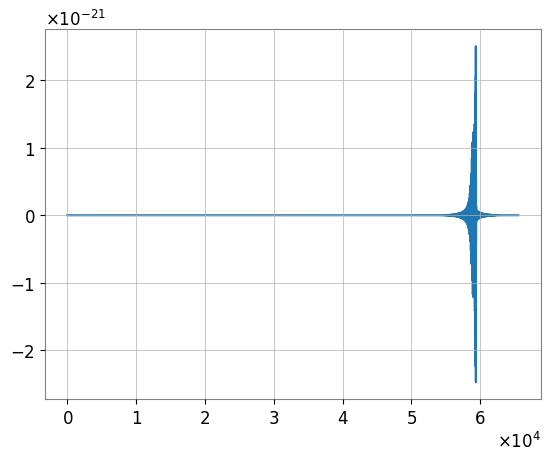

In [18]:
out = gen.apply(params_orchid)
print(len(out[1])/2048.)
plt.plot(out[1][:])

In [ ]:
# We are doing about 200 per second
start = time.time()
for n in range(200):
    out = gen.apply(params_orchid)
end = time.time() - start
print('Time taken for fastgen class = {} seconds'.format(end))

In [7]:
pycbc.DYN_RANGE_FAC

5.902958103587057e+20

In [ ]:
class FastGenerateWaveform():
    ## Used to augment on all parameters (uses GPU-accelerated IMRPhenomPv2 waveform generation)
    ## Link to Ripple: https://github.com/tedwards2412/ripple
    def __init__(self):
        # Generate the frequency grid (default values)
        self.f_lower = 20.
        self.f_upper = 2048.
        self.delta_f = 0.25
        self.delta_t = 1./2048.
        self.sample_length_in_s = 1./self.delta_f
        self.f_ref = self.f_lower
        # Clean-up params
        self.rwrap = 3.0
        # Tapering params
        beta = 8
        # Condition for optimise f_min
        self.duration_padfactor = 1.1
        # Pick the longest waveform from priors to make some params static
        # Below params are for m1 = 5.01, m2 = 5.0 and with aligned spins s1z, s2z = 0.99
        _theta = {'mass1': 5.01, 'mass2': 5.0, 'spin1z': 0.99, 'spin2z': 0.99}
        self.tmp_f_lower, self.tmp_delta_f, self.fsize = self.optimise_fmin(_theta)
        # Get the fseries over which we get the waveform in FD
        self.fseries = jnp.append(jnp.arange(0.0, self.f_upper, self.tmp_delta_f), self.f_upper)
        fseries_trunc = self.fseries[:self.fsize]
        self.cshift = jnp.exp(-2j*jnp.pi*(-self.rwrap)*fseries_trunc)
        self.clean_idx = self.fseries < self.tmp_f_lower
        # Windowing params
        self.width = self.f_lower - self.tmp_f_lower
        self.winlen = int(2. * (self.width / self.tmp_delta_f))
        self.window = np.array(get_window(('kaiser', beta), self.winlen))
        self.kmin = int(self.tmp_f_lower / self.tmp_delta_f)
        self.kmax = self.kmin + self.winlen//2

        # Projection params
        self.signal_length = 12.0 # seconds
        self.whiten_padding = 5.0 # seconds
        self.error_padding_in_s = 0.5 # seconds
    
    def __str__(self):
        data = "f_lower = {}, f_upper = {}, \n \
        delta_f = {}, delta_t = {}, f_ref = {}, \n \
        rwrap = {}".format(self.f_lower, self.f_upper, self.delta_f,
                                   self.delta_t, self.f_ref, self.rwrap)
        return data

    """ ONE-OFF FUNCTIONS (Dont't require JAX or to be jitted in any way) """
    def ms_to_Mc_eta(self, masses):
        ## Converts binary component masses to chirp mass and symmetric mass ratio.
        m1, m2 = masses
        return (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5), m1 * m2 / (m1 + m2) ** 2

    def get_imr_duration(self, theta, f_lower):
        # This function is applicable for IMRPhenomD and IMRPhenomPv2
        # Multiplying by a factor of 1.1 for overestimate of signal duration
        return 1.1 * lalsim.SimIMRPhenomDChirpTime(theta['mass1']*1.989e+30, theta['mass2']*1.989e+30, 
                                                   theta['spin1z'], theta['spin2z'], 
                                                   f_lower)
    
    def nearest_larger_binary_number(self, input_len):
        # Return the nearest binary number larger than input_len.
        return int(2**np.ceil(np.log2(input_len)))

    def optimise_fmin(self, theta):
        ## NOTE: We find that even for the longest duration waveform we deal with
        ## the value of f_lower is still 17.02 Hz (we can fix this value and remove this function)
        # determine the duration to use
        full_duration = duration = self.get_imr_duration(theta, self.f_lower)
        tmp_f_lower = self.f_lower
        while True:
            # This iteration is typically done 16 times
            full_duration = self.get_imr_duration(theta, tmp_f_lower)
            condition = duration * self.duration_padfactor
            if full_duration >= condition:
                break
            else:
                # We can change this to tmp_f_lower -= 3.0 to lower iterations
                # It will consequently increase the time taken for waveform generation process
                # But, we've already seen that this shouldn't matter much for Ripple
                # tmp_f_lower *= 0.99 is consistent with PyCBC docs
                tmp_f_lower *= 0.99

        # factor to ensure the vectors are all large enough. We don't need to
        # completely trust our duration estimator in this case, at a small
        # increase in computational cost
        fudge_duration = (full_duration + .1 + self.rwrap) * self.duration_padfactor
        fsamples = int(fudge_duration / self.delta_t)
        N = self.nearest_larger_binary_number(fsamples)
        fudge_duration = N * self.delta_t

        tmp_delta_f = 1.0 / fudge_duration
        tsize = int(1.0 / self.delta_t /  tmp_delta_f)
        fsize = tsize // 2 + 1

        return (tmp_f_lower, tmp_delta_f, fsize)
    
    """ NON-JITTABLES """
    # Using jnp and jitting this function caused significant slowdown
    # Might have something to do with multiple compilations
    def ripple_cleanup(self, hpol):
        # Add the 0th frequency bin back into the fseries
        hpol = np.insert(hpol, 0, 0)
        # ad-hoc high pass filtering
        hpol[self.clean_idx] = 0.0
        return hpol
    
    """ JITTABLES """
    # Jitting these functions require the first argument (self) to be defined as static
    @partial(jax.jit, static_argnums=(0,))
    def ripple_cleanup_jitted(self, hpol):
        # Add the 0th frequency bin back into the fseries
        hpol = jnp.insert(hpol, 0, 0)
        # ad-hoc high pass filtering
        hpol = hpol.at[self.clean_idx].set(0.0)
        return hpol
    
    @partial(jax.jit, static_argnums=(0,))
    def convert_to_timeseries(self, hpol):
        ## Convert frequency series to time series
        return jnp.fft.irfftn(hpol) * (1./self.delta_t)
    
    @partial(jax.jit, static_argnums=(0,))
    def fd_taper_left(self, out):
        # Apply Tapering
        out = out.at[self.kmin:self.kmax].set(out[self.kmin:self.kmax] * self.window[:self.winlen//2])
        out = out.at[:self.kmin].set(out[:self.kmin] * 0.)
        # Convert frequency series to time series
        out = self.convert_to_timeseries(out)
        return out
    
    @partial(jax.jit, static_argnums=(0,))
    def cyclic_time_shift(self, hpol):
        return hpol * self.cshift

    @partial(jax.jit, static_argnums=(0,))
    def resize(self, hpol):
        # Use jnp to speed things up
        return hpol[0:self.fsize]

    def get_theta_ripple(self, theta):
        # Convert the prior values to jnp array
        # Following params are required for IMRPhenomPv2
        # m1_msun, m2_msun, s1x, s1y, s1z, s2x, s2y, s2z, distance_mpc, tc, phiRef, inclination
        Mc, eta = self.ms_to_Mc_eta(jnp.array([theta[0], theta[1]]))
        theta_ripple = jnp.append(jnp.array([Mc, eta]), jnp.array(theta[2:]))
        return theta_ripple

    @partial(jax.jit, static_argnums=(0,))
    def get_hphc(self, theta, fseries):
        # Get the IMRPhenomPv2 waveform using Ripple
        return gen_IMRPhenomPv2_hphc(fseries[1:], theta, self.f_lower)

    """ MAIN """
    def make_injection(self, hp, hc):
        # Get the required sample length and tc
        sample_length_in_s = len(hp)/2048.
        tc_obs = sample_length_in_s - self.rwrap
        tc_req = np.random.uniform(low=11.0, high=11.2)
        start_time = tc_obs - tc_req
        end_time = tc_obs + (self.signal_length - tc_req)
        # Pad the start and end times for whitening and error padding
        start_time -= (self.whiten_padding/2.0 + self.error_padding_in_s)
        end_time += (self.whiten_padding/2.0 + self.error_padding_in_s)
        # Pad hpol with zeros (append or prepend) if necessary
        left_pad = int(-start_time * 2048.) if start_time < 0.0 else 0
        right_pad = int((end_time-sample_length_in_s) * 2048.) if end_time > sample_length_in_s else 0
        hp = np.pad(hp, (left_pad, right_pad), 'constant', constant_values=(0.0, 0.0))
        hc = np.pad(hc, (left_pad, right_pad), 'constant', constant_values=(0.0, 0.0))
        # Slice the required section out of hpol
        start_idx = int(start_time*2048.) if start_time > 0.0 else 0
        end_idx = int(end_time*2048.) + int(left_pad)
        slice_idx = slice(start_idx, end_idx)
        hp = hp[slice_idx]
        hc = hc[slice_idx]
        return ((hp, hc), tc_req)

    def project(self, hp, hc, special):
        # Get hp, hc in the time domain and convert to h(t)
        ## Get random value (with a given prior) for polarisation angle, ra, dec
        # Polarisation angle
        pol_angle = special['distrs']['pol'].rvs()[0][0]
        # Right ascension, declination
        sky_pos = special['distrs']['sky'].rvs()[0]
        declination, right_ascension = sky_pos
        # Use project_wave and random realisation of polarisation angle, ra, dec to obtain augmented signal
        strains = [det.project_wave(hp, hc, right_ascension, declination, pol_angle) for det in self.dets]
        return strains

    def generate(self, _theta):
        theta = _theta.copy()
        ## Generate waveform on the fly using GPU-accelerated Ripple
        # Convert theta to theta_ripple (jnp) (only required params)
        theta_ripple = self.get_theta_ripple(theta)
        # Get h_plus and h_cross from the given waveform parameters theta
        # Note than hp and hc are in the frequency domain
        hp, hc = self.get_hphc(theta_ripple, self.fseries)
        # Ripple specific clean-up
        hp = self.ripple_cleanup(hp)
        hc = self.ripple_cleanup(hc)
        # Resizing (to the required sample rate)
        hp = self.resize(hp)
        hc = self.resize(hc)
        # Cyclic time-shift
        hp = self.cyclic_time_shift(hp)
        hc = self.cyclic_time_shift(hc)
        # Tapering and fd_to_td
        hp_td = self.fd_taper_left(hp)
        hc_td = self.fd_taper_left(hc)
        
        return hp_td, hc_td
    
    def apply(self, params: dict, special: dict):
        # Set lal.Detector object as global as workaround for MP methods
        # Project wave does not work with DataLoader otherwise
        setattr(self, 'dets', special['dets'])
        # Augmentation on all params
        hp, hc = self.generate(params)
        # Make hp, hc into proper injection (adjust to tc and zero pad)
        (hp, hc), tc = self.make_injection(hp, hc)
        injection_params = {'tc': tc}
        # Convert hp, hc into h(t) using antenna pattern (H1, L1 considered)
        out = self.project(hp, hc, special)
        # Input: (h_plus, h_cross) --> output: (det1 h_t, det_2 h_t)
        return (out, injection_params)